In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import qiime2 as q2
from qiime2.plug
import biom
import h5py
import pandas as pd 
import numpy as np
import scipy.stats as ss
import skbio

In [2]:
# load mass spec table and metadata
ms_ft = q2.Artifact.load('20210716_FBMN/qiime2_output/qiime2_table.qza').view(biom.Table)
md = pd.read_csv('pths_study_specific_metadata.tsv', sep='\t',dtype='str').set_index('#SampleID')
md = md.replace({'is_affected': 'PTHS', 'is_not_affected': 'Parents'})

In [3]:
# only keep those with PH ID & rename ids to match AGP 
ms_ft = ms_ft.filter({i for i in ms_ft.ids() if i.startswith('PH')}).remove_empty()
ms_ft = ms_ft.update_ids({i: "10317.000%s" % i[2:8] for i in ms_ft.ids()}, inplace=False)

# also filter so that we only keep samples we have metadata for 
ms_ft = ms_ft.filter(set(md.index) & set(ms_ft.ids()), inplace=False).remove_empty()
ms_ft

1157 x 84 <class 'biom.table.Table'> with 10845 nonzero entries (11% dense)

In [33]:
# make a biom table with the proper sample ids  
f = h5py.File('pths_ms_table.biom', 'w')
ms_ft.to_hdf5(f, 'asd')
f.close()

# import this biom table to q2 artifact 
!qiime tools import \
    --input-path pths_ms_table.biom \
    --type 'FeatureTable[Frequency]' \
    --input-format BIOMV210Format \
    --output-path pths_ms_table.qza

Imported pths_ms_table.biom as BIOMV210Format to pths_ms_table.qza


# Songbird 

Here we are interested in determining a formula that can fit pths_status well. There are a few different ones we wanted to look into. 
* pths_status 
* pths_status+age_years
* pths_status+age_years filtering PTHS individuals to only those under 20 (as in Figure 1) 
* pths_status but features must be present in at least 3 samples 
* pths_status+age_years but features must be present in at least 3 samples 

### pths_status alone 

In [35]:
!mkdir songbird

In [36]:
# run songbird on metabolomics feature table
# first we'll do the null songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_table.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --p-formula "1" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird/differentials_null.qza \
    --o-regression-stats songbird/regression_stats_null.qza \
    --o-regression-biplot songbird/regression_biplot_null.qza

# run pths_status songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_table.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --p-formula "pths_status" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird/differentials_pths_status.qza \
    --o-regression-stats songbird/regression_stats_pths_status.qza \
    --o-regression-biplot songbird/regression_biplot_pths_status.qza

Saved FeatureData[Differential] to: songbird/differentials_null.qza
Saved SampleData[SongbirdStats] to: songbird/regression_stats_null.qza
Saved PCoAResults % Properties('biplot') to: songbird/regression_biplot_null.qza
Saved FeatureData[Differential] to: songbird/differentials_pths_status.qza
Saved SampleData[SongbirdStats] to: songbird/regression_stats_pths_status.qza
Saved PCoAResults % Properties('biplot') to: songbird/regression_biplot_pths_status.qza


In [4]:
# check the performance of the model 
!qiime songbird summarize-paired \
    --i-regression-stats songbird/regression_stats_pths_status.qza \
    --i-baseline-stats songbird/regression_stats_null.qza \
    --o-visualization songbird/pths_status.qzv

!qiime tools view songbird/pths_status.qzv

Saved Visualization to: songbird/pths_status.qzv
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

### pths_status+age_years

In [38]:
# this requires filtering to those who have provided age 
md_w_age = md.loc[md['age_years'] != "Missing: Not provided"]
md_w_age['age_years'] = md_w_age['age_years'].astype("float64")
md_w_age.to_csv('pths_metadata_age_float.tsv', sep='\t')

# filter the ms feature table so that we only keep samples filtered above 
ms_ft = ms_ft.filter(set(md_w_age.index) & set(ms_ft.ids()), inplace=False).remove_empty()
ms_ft

/Users/hazedil/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1155 x 76 <class 'biom.table.Table'> with 10050 nonzero entries (11% dense)

In [39]:
# write filtered table to .biom table
f = h5py.File('pths_ms_age.biom', 'w')
ms_ft.to_hdf5(f, 'asd')
f.close()

# import filtered table into qiime qza 
!qiime tools import \
  --input-path pths_ms_age.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_age.qza

Imported pths_ms_age.biom as BIOMV210Format to pths_ms_age.qza


In [40]:
!mkdir songbird_age

In [42]:
# run songbird on metabolomics feature table
# first we'll do the null songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_age.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "1" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird_age/differentials_null.qza \
    --o-regression-stats songbird_age/regression_stats_null.qza \
    --o-regression-biplot songbird_age/regression_biplot_null.qza

# run pths_status songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_age.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "pths_status+age_years" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird_age/differentials_pths_status.qza \
    --o-regression-stats songbird_age/regression_stats_pths_status.qza \
    --o-regression-biplot songbird_age/regression_biplot_pths_status.qza

Saved FeatureData[Differential] to: songbird_age/differentials_null.qza
Saved SampleData[SongbirdStats] to: songbird_age/regression_stats_null.qza
Saved PCoAResults % Properties('biplot') to: songbird_age/regression_biplot_null.qza
Saved FeatureData[Differential] to: songbird_age/differentials_pths_status.qza
Saved SampleData[SongbirdStats] to: songbird_age/regression_stats_pths_status.qza
Saved PCoAResults % Properties('biplot') to: songbird_age/regression_biplot_pths_status.qza


In [5]:
# check the performance of the model 
!qiime songbird summarize-paired \
    --i-regression-stats songbird_age/regression_stats_pths_status.qza \
    --i-baseline-stats songbird_age/regression_stats_null.qza \
    --o-visualization songbird_age/pths_status_age.qzv

!qiime tools view songbird_age/pths_status_age.qzv

Saved Visualization to: songbird_age/pths_status_age.qzv
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

### pths_status+age_years but only pths individuals < 20 

In [44]:
# also filter to PTHS individuals < 20 & unaffected individuals 
samples_to_keep = md_w_age.loc[(md_w_age['age_years'] < 20) | (md_w_age['pths_status'] == 'is_not_affected')].index
ms_ft = ms_ft.filter(set(samples_to_keep) & set(ms_ft.ids()), inplace=False).remove_empty()
ms_ft

1155 x 72 <class 'biom.table.Table'> with 9784 nonzero entries (11% dense)

In [45]:
# write filtered table to .biom table
f = h5py.File('pths_ms_youngpths_unaffected.biom', 'w')
ms_ft.to_hdf5(f, 'asd')
f.close()

# import filtered table into qiime qza 
!qiime tools import \
  --input-path pths_ms_youngpths_unaffected.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_youngpths_unaffected.qza

Imported pths_ms_youngpths_unaffected.biom as BIOMV210Format to pths_ms_youngpths_unaffected.qza


In [46]:
!mkdir songbird_filtered

In [47]:
# run songbird on metabolomics feature table
# first we'll do the null songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_youngpths_unaffected.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "1" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird_filtered/differentials_null.qza \
    --o-regression-stats songbird_filtered/regression_stats_null.qza \
    --o-regression-biplot songbird_filtered/regression_biplot_null.qza

# run pths_status songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_youngpths_unaffected.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "pths_status+age_years" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird_filtered/differentials_pths_status.qza \
    --o-regression-stats songbird_filtered/regression_stats_pths_status.qza \
    --o-regression-biplot songbird_filtered/regression_biplot_pths_status.qza

Saved FeatureData[Differential] to: songbird_filtered/differentials_null.qza
Saved SampleData[SongbirdStats] to: songbird_filtered/regression_stats_null.qza
Saved PCoAResults % Properties('biplot') to: songbird_filtered/regression_biplot_null.qza
Saved FeatureData[Differential] to: songbird_filtered/differentials_pths_status.qza
Saved SampleData[SongbirdStats] to: songbird_filtered/regression_stats_pths_status.qza
Saved PCoAResults % Properties('biplot') to: songbird_filtered/regression_biplot_pths_status.qza


In [6]:
# check the performance of the model 
!qiime songbird summarize-paired \
    --i-regression-stats songbird_filtered/regression_stats_pths_status.qza \
    --i-baseline-stats songbird_filtered/regression_stats_null.qza \
    --o-visualization songbird_filtered/pths_status_age.qzv

!qiime tools view songbird_filtered/pths_status_age.qzv

Saved Visualization to: songbird_filtered/pths_status_age.qzv
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

### pths_status, but filtered to only features present in at least three samples 

In [49]:
!qiime feature-table filter-features \
    --i-table pths_ms_table.qza \
    --p-min-samples 3 \
    --o-filtered-table pths_ms_table_min3samples.qza

Saved FeatureTable[Frequency] to: pths_ms_table_min3samples.qza


In [50]:
# run songbird on metabolomics feature table
# first we'll do the null songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_table_min3samples.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --p-formula "1" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird/differentials_null_min3.qza \
    --o-regression-stats songbird/regression_stats_null_min3.qza \
    --o-regression-biplot songbird/regression_biplot_null_min3.qza

# run pths_status songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_table_min3samples.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --p-formula "pths_status" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird/differentials_pths_status_min3.qza \
    --o-regression-stats songbird/regression_stats_pths_status_min3.qza \
    --o-regression-biplot songbird/regression_biplot_pths_status_min3.qza

Saved FeatureData[Differential] to: songbird/differentials_null_min3.qza
Saved SampleData[SongbirdStats] to: songbird/regression_stats_null_min3.qza
Saved PCoAResults % Properties('biplot') to: songbird/regression_biplot_null_min3.qza
Saved FeatureData[Differential] to: songbird/differentials_pths_status_min3.qza
Saved SampleData[SongbirdStats] to: songbird/regression_stats_pths_status_min3.qza
Saved PCoAResults % Properties('biplot') to: songbird/regression_biplot_pths_status_min3.qza


In [7]:
# check the performance of the model 
!qiime songbird summarize-paired \
    --i-regression-stats songbird/regression_stats_pths_status_min3.qza \
    --i-baseline-stats songbird/regression_stats_null_min3.qza \
    --o-visualization songbird/pths_status_min3.qzv

!qiime tools view songbird/pths_status_min3.qzv

Saved Visualization to: songbird/pths_status_min3.qzv
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

### pths_status+age_years, but filtered to only features present in at least three samples 

In [54]:
# try filtering ms age feature table to only 3 features 
!qiime feature-table filter-features \
    --i-table pths_ms_age.qza \
    --p-min-samples 3 \
    --o-filtered-table pths_ms_age_min3samples.qza

Saved FeatureTable[Frequency] to: pths_ms_age_min3samples.qza


In [55]:
# run songbird on metabolomics feature table
# first we'll do the null songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_age_min3samples.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "1" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird_age/differentials_null_min3.qza \
    --o-regression-stats songbird_age/regression_stats_null_min3.qza \
    --o-regression-biplot songbird_age/regression_biplot_null_min3.qza

# run pths_status songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_age_min3samples.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "pths_status+age_years" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials songbird_age/differentials_pths_status_min3.qza \
    --o-regression-stats songbird_age/regression_stats_pths_status_min3.qza \
    --o-regression-biplot songbird_age/regression_biplot_pths_status_min3.qza

Saved FeatureData[Differential] to: songbird_age/differentials_null_min3.qza
Saved SampleData[SongbirdStats] to: songbird_age/regression_stats_null_min3.qza
Saved PCoAResults % Properties('biplot') to: songbird_age/regression_biplot_null_min3.qza
Saved FeatureData[Differential] to: songbird_age/differentials_pths_status_min3.qza
Saved SampleData[SongbirdStats] to: songbird_age/regression_stats_pths_status_min3.qza
Saved PCoAResults % Properties('biplot') to: songbird_age/regression_biplot_pths_status_min3.qza


In [8]:
# check the performance of the model 
!qiime songbird summarize-paired \
    --i-regression-stats songbird_age/regression_stats_pths_status_min3.qza \
    --i-baseline-stats songbird_age/regression_stats_null_min3.qza \
    --o-visualization songbird_age/pths_status_age_min3.qzv

!qiime tools view songbird_age/pths_status_age_min3.qzv

Saved Visualization to: songbird_age/pths_status_age_min3.qzv
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [58]:
# made model worse, so i think the best Songbird to use is going to be the one with features that are present in min 3 samples 
# filter table so that we only have the features used by songbird 
tabms = biom.load_table('pths_ms_table.biom')
s_diffs = q2.Artifact.load('songbird/differentials_pths_status_min3.qza').view(pd.DataFrame)
sb = tabms.filter(set(s_diffs.index), inplace=False, axis='observation').remove_empty()

f = h5py.File('pths_ms_used_by_songbird.biom', 'w')
sb.to_hdf5(f, 'asd')
f.close()

!qiime tools import \
  --input-path pths_ms_used_by_songbird.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_used_by_songbird.qza

# now that we have feature table filtered to those features used by songbird, we can run mmvec 
t_sg = q2.Artifact.load('Pitt_Hopkins_shotgun_shogun_gotu_min3samples.qza').view(biom.Table)
t_ms = q2.Artifact.load('pths_ms_used_by_songbird.qza').view(biom.Table)

# notice how each table above has different numbers of samples 
# filter tables so that they all have same samples
t_sg.filter(set(t_ms.ids()) & set(t_sg.ids()), inplace=True).remove_empty()
t_ms.filter(set(t_ms.ids()) & set(t_sg.ids()), inplace=True).remove_empty()

# write filtered shotgun data 
f = h5py.File('pths_shotgun_shogun_for_mmvec.biom', 'w')
t_sg.to_hdf5(f, 'asd')
f.close()

# write filtered ms data 
f = h5py.File('pths_ms_for_mmvec.biom', 'w')
t_ms.to_hdf5(f, 'asd')
f.close()

# import filtered data into qiime
!qiime tools import \
  --input-path pths_shotgun_shogun_for_mmvec.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_shotgun_shogun_for_mmvec.qza
!qiime tools import \
  --input-path pths_ms_for_mmvec.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_for_mmvec.qza

Imported pths_ms_used_by_songbird.biom as BIOMV210Format to pths_ms_used_by_songbird.qza
Imported pths_shotgun_shogun_for_mmvec.biom as BIOMV210Format to pths_shotgun_shogun_for_mmvec.qza
Imported pths_ms_for_mmvec.biom as BIOMV210Format to pths_ms_for_mmvec.qza


# mmvec 

\# run mmvec 

qiime mmvec paired-omics \
	--i-microbes pths_shotgun_shogun_for_mmvec.qza \
	--i-metabolites pths_ms_for_mmvec.qza \
	--m-metadata-file pths_study_specific_metadata.tsv \
	--o-conditionals PTHS_shogun_ms_conditionals.qza \
	--o-conditional-biplot PTHS_shogun_ms_conditional_biplot.qza \
	--o-model-stats PTHS_shogun_ms_model_stats.qza


# Figures showing alpha & beta diversity of metabolites; pths versus parents 

In [1]:
!qiime feature-table summarize \
    --i-table pths_ms_table.qza \
    --m-sample-metadata-file pths_study_specific_metadata.tsv \
    --o-visualization table_summary.qzv 

Saved Visualization to: table_summary.qzv


In [4]:
!qiime diversity core-metrics \
    --i-table pths_ms_table.qza \
    --p-sampling-depth 5000000 \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --output-dir core-metrics-results

Saved FeatureTable[Frequency] to: core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results/bray_curtis_pcoa_results.qza
Saved Visualization to: core-metrics-results/jaccard_emperor.qzv
Saved Visualization to: core-metrics-results/bray_curtis_emperor.qzv


In [137]:
!qiime diversity beta \
    --i-table pths_ms_table.qza \
    --p-metric cosine \
    --o-distance-matrix cosine_distance_matrix.qza

Saved DistanceMatrix to: cosine_distance_matrix.qza


In [5]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity core-metrics-results/shannon_vector.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --o-visualization shannon_div.qzv

Saved Visualization to: shannon_div.qzv


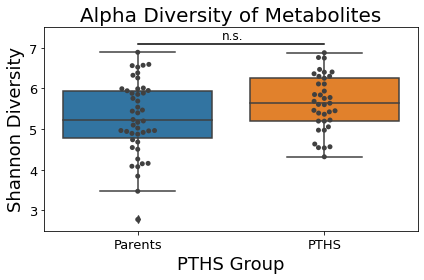

In [141]:
# downloaded raw data as tsv from the qiime core metrics results 
a_div = pd.read_csv('core-metrics-results/shannon-data.tsv', sep='\t', skiprows = lambda x: x in [1], index_col='id')
a_div = a_div[['pths_status', 'shannon_entropy']]
a_div = a_div.replace({'is_affected': 'PTHS', 'is_not_affected': 'Parents'}).sort_values(by='shannon_entropy')

plt.figure()
plt.title('Alpha Diversity of Metabolites', size=20)
plt.ylim(2.5, 7.5)
sns.boxplot(data=a_div, x='pths_status', y='shannon_entropy')
sns.swarmplot(data=a_div, x='pths_status', y='shannon_entropy', color=".25")
ax = plt.gca()
plt.plot([0, 1], [7.1, 7.1], linestyle = 'solid', c='k')
ax.text(0.45, 7.2, 'n.s.', fontsize=12)
ax.set_ylabel("Shannon Diversity", fontsize=18)
ax.set_xlabel("PTHS Group", fontsize=18)
ax.tick_params(labelsize=13)
plt.tight_layout()
plt.savefig('alpha_div_pths_parents.pdf')

In [71]:
# Kruskal Wallis 
pths = a_div.loc[a_div['pths_status']=='PTHS']['shannon_entropy']
parents = a_div.loc[a_div['pths_status']=='Parents']['shannon_entropy']

ss.kruskal(pths, parents)

KruskalResult(statistic=3.3239046499916185, pvalue=0.06827948258233053)

In [142]:
!qiime diversity beta-group-significance \
    --i-distance-matrix cosine_distance_matrix.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --m-metadata-column pths_status \
    --o-visualization cosine_sig.qzv

Saved Visualization to: cosine_sig.qzv


In [1]:
!qiime diversity beta-group-significance \
    --i-distance-matrix core-metrics-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --m-metadata-column pths_status \
    --o-visualization pths_status_bc_sig.qzv

Saved Visualization to: pths_status_bc_sig.qzv


In [7]:
!qiime diversity beta-group-significance \
    --i-distance-matrix core-metrics-results/jaccard_distance_matrix.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --m-metadata-column pths_status \
    --o-visualization pths_status_jaccard_sig.qzv

Saved Visualization to: pths_status_jaccard_sig.qzv


Text(0.5, 1.0, 'Jaccard PCoA')

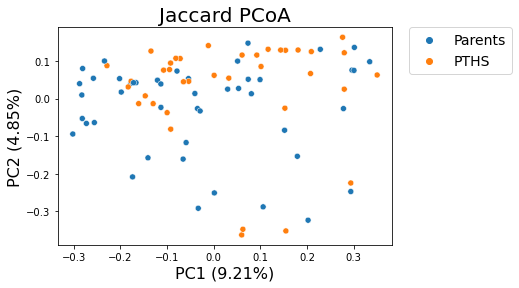

In [7]:
# 2D Jaccard plot 
ordination = q2.Artifact.load('core-metrics-results/jaccard_pcoa_results.qza').view(skbio.OrdinationResults)
ord_2d = ordination.samples[[0, 1]]
ord_2d = ord_2d.rename(columns={0:'PC1', 1:'PC2'})
ord_2d = ord_2d.merge(md[['pths_status']], left_index=True, right_index=True)
ord_2d = ord_2d.replace(['is_affected', 'is_not_affected'], ['PTHS', 'Parents'])

plt.figure()
sns.scatterplot(data=ord_2d, x='PC1', y='PC2', hue='pths_status', hue_order=['Parents', 'PTHS'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
ax = plt.gca()
ax.set_ylabel('PC2 (4.85%)', size=16)
ax.set_xlabel('PC1 (9.21%)', size=16)
plt.title("Jaccard PCoA", fontsize=20)

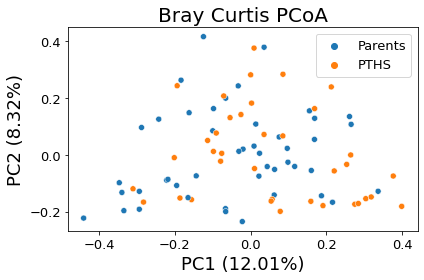

In [151]:
# 2D Bray Curtis plot 
ordination = q2.Artifact.load('core-metrics-results/bray_curtis_pcoa_results.qza').view(skbio.OrdinationResults)
ord_2d = ordination.samples[[0, 1]]
ord_2d = ord_2d.rename(columns={0:'PC1', 1:'PC2'})
ord_2d = ord_2d.merge(md[['pths_status']], left_index=True, right_index=True)
ord_2d = ord_2d.replace(['is_affected', 'is_not_affected'], ['PTHS', 'Parents'])

plt.figure()
sns.scatterplot(data=ord_2d, x='PC1', y='PC2', hue='pths_status', hue_order=['Parents', 'PTHS'])
plt.legend(fontsize=13)
ax = plt.gca()
ax.set_ylabel('PC2 (8.32%)', size=18)
ax.set_xlabel('PC1 (12.01%)', size=18)
ax.tick_params(labelsize=13)
plt.title("Bray Curtis PCoA", fontsize=20)
plt.tight_layout()
plt.savefig('bray_curtis_pcoa.pdf')

# Songbird & mmvec figures

In [3]:
# load the Songbird differentials table, mmvec ranks, and mmvec biplot 
ms_diff = q2.Artifact.load('songbird/differentials_pths_status_min3.qza').view(pd.DataFrame)
mmvec_ranks = q2.Artifact.load('mmvec/PTHS_shogun_ms_conditionals.qza').view(pd.DataFrame)
mmvec_biplot = q2.Artifact.load('mmvec/PTHS_shogun_ms_conditional_biplot.qza').view(skbio.OrdinationResults)

In [4]:
# load GNPS annotations 
annots = pd.read_csv('20210716_FBMN/DB_result/library_result.tsv', sep='\t', dtype='str')
annots = annots.set_index('#Scan#')

# filter annotations to those in the feature table 
ms_feats = q2.Artifact.load('pths_ms_table.qza').view(pd.DataFrame)
annots = annots.loc[annots.index & ms_feats.columns]

# filter to specific feature types that i'm interested in 
pegs = annots.loc[annots['Compound_Name'].str.contains('glycol')]
bile_acids = annots.loc[annots['subclass'] == 'Bile acids, alcohols and derivatives']
phosphos = annots.loc[annots['Compound_Name'].str.contains('phospho')]
ba_prec = annots.loc[annots['Compound_Name'].str.contains('Choles')]

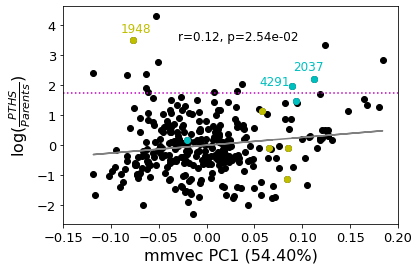

In [175]:
# Songbird versus mmvec PC1 
x = mmvec_biplot.samples[0]
y = -1 * ms_diff['pths_status[T.is_not_affected]']
# bile acids 
x_ba = mmvec_biplot.samples.loc[(bile_acids.index & ms_diff.index)][0]
y_ba = -1 * ms_diff.loc[(bile_acids.index & ms_diff.index)]['pths_status[T.is_not_affected]']
# phosphocholines 
x_p = mmvec_biplot.samples.loc[(phosphos.index & ms_diff.index)][0]
y_p = -1 * ms_diff.loc[(phosphos.index & ms_diff.index)]['pths_status[T.is_not_affected]']

plt.scatter(x, y, color='k')
plt.scatter(x_ba, y_ba, color='c')
plt.scatter(x_p, y_p, color='y')
plt.scatter(x_bap, y_bap, color='m')
plt.xlim(-.15, .20)
ax = plt.gca()
ax.set_xlabel("mmvec PC1 (%0.2f%%)" % (mmvec_biplot.proportion_explained[0] * 100), fontsize=16)
ax.set_ylabel(r"log($\frac{PTHS}{Parents})$", fontsize=16)

# line of best fit 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"tab:gray")
ax.text(-0.03, 3.5, "r=%0.2f, p=%0.2e" % ss.spearmanr(x,y), fontsize=12)

# add annotations 
ax.text(.09, 2.5, '2037', fontsize=12, c='c')
ax.text(.055, 2, '4291', fontsize=12, c='c')
ax.text(-0.09, 3.75, '1948', fontsize=12, c='y')

ax.tick_params(labelsize=13)

# cutoff determined for top Songbird features 
plt.plot([-0.15, 0.20], [1.75, 1.75], linestyle = 'dotted', c='m')

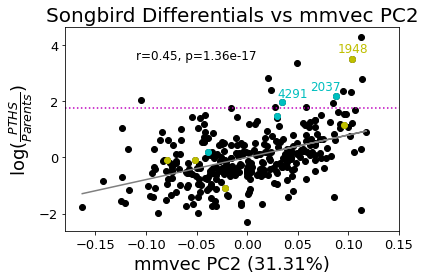

In [177]:
# Songbird versus mmvec PC1 
x = mmvec_biplot.samples[1]
y = -1 * ms_diff['pths_status[T.is_not_affected]']
# bile acids 
x_ba = mmvec_biplot.samples.loc[(bile_acids.index & ms_diff.index)][1]
y_ba = -1 * ms_diff.loc[(bile_acids.index & ms_diff.index)]['pths_status[T.is_not_affected]']
# phosphocholines 
x_p = mmvec_biplot.samples.loc[(phosphos.index & ms_diff.index)][1]
y_p = -1 * ms_diff.loc[(phosphos.index & ms_diff.index)]['pths_status[T.is_not_affected]']

plt.scatter(x, y, color='k')
plt.scatter(x_ba, y_ba, color='c')
plt.scatter(x_p, y_p, color='y')
plt.xlim(-.18, .15)
plt.title('Songbird Differentials vs mmvec PC2', fontsize=20)
ax = plt.gca()
ax.set_xlabel("mmvec PC2 (%0.2f%%)" % (mmvec_biplot.proportion_explained[1] * 100), fontsize=18)
ax.set_ylabel(r"log($\frac{PTHS}{Parents})$", fontsize=18)
ax.tick_params(labelsize=13)

# line of best fit 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"tab:gray")
ax.text(-0.11, 3.5, "r=%0.2f, p=%0.2e" % ss.spearmanr(x,y), fontsize=12)

# add annotations 
ax.text(.062, 2.4, '2037', fontsize=12, c='c')
ax.text(0.03, 2.15, '4291', fontsize=12, c='c')
ax.text(0.09, 3.75, '1948', fontsize=12, c='y')

# cutoff determined for top Songbird features 
plt.plot([-0.18, 0.15], [1.75, 1.75], linestyle = 'dotted', c='m')
plt.tight_layout()
plt.savefig('songbird_mmvec.pdf')

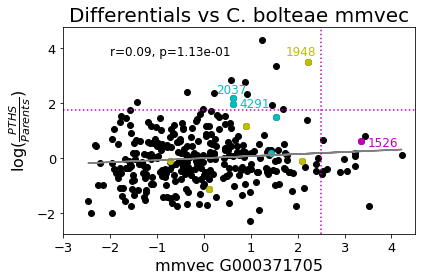

In [21]:
x = mmvec_ranks['G000371705']
y = -1*ms_diff['pths_status[T.is_not_affected]']
# bile acids 
x_ba = mmvec_ranks['G000371705'][bile_acids.index.astype('int') & mmvec_ranks.index]
y_ba = -1 * ms_diff.loc[(bile_acids.index & ms_diff.index)]['pths_status[T.is_not_affected]']
# phosphocholines 
x_p = mmvec_ranks['G000371705'][phosphos.index.astype('int') & mmvec_ranks.index]
y_p = -1 * ms_diff.loc[(phosphos.index & ms_diff.index)]['pths_status[T.is_not_affected]']
# bile acid prec
x_bap = mmvec_ranks['G000371705'][ba_prec.index.astype('int') & mmvec_ranks.index]
y_bap = -1 * ms_diff.loc[(ba_prec.index & ms_diff.index)]['pths_status[T.is_not_affected]']

plt.scatter(x, y, color='k')
plt.scatter(x_ba, y_ba, color='c')
plt.scatter(x_p, y_p, color='y')
plt.scatter(x_bap, y_bap, color='m')
plt.xlim(-3, 4.5)
plt.ylim(-2.75, 4.75)
plt.title('Differentials vs C. bolteae mmvec', fontsize=20)
ax = plt.gca()
ax.set_xlabel("mmvec G000371705", fontsize=16)
ax.set_ylabel(r"log($\frac{PTHS}{Parents})$", fontsize=16)
ax.tick_params(labelsize=13)

# line of best fit 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"tab:gray")
ax.text(-2, 3.75, "r=%0.2f, p=%0.2e" % ss.spearmanr(x,y), fontsize=12)

#cutoff for significance 
plt.plot([-3, 5], [1.75, 1.75], linestyle = 'dotted', c='m')
plt.plot([2.5, 2.5], [-2.75, 4.75], linestyle = 'dotted', c='m')

# add annotations 
ax.text(0.27, 2.35, '2037', fontsize=12, c='c')
ax.text(.75, 1.85, '4291', fontsize=12, c='c')
ax.text(1.75, 3.75, '1948', fontsize=12, c='y')
ax.text(3.5, 0.45, '1526', fontsize=12, c='m')

plt.tight_layout()
plt.savefig('songbird_cbolteae.pdf')

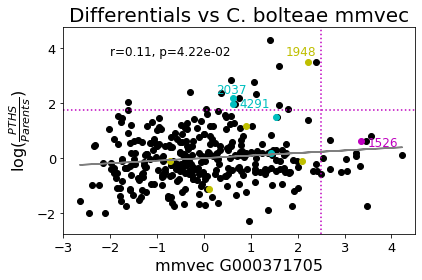

In [22]:
x = mmvec_ranks['G000431175']
y = -1*ms_diff['pths_status[T.is_not_affected]']
# bile acids 
x_ba = mmvec_ranks['G000371705'][bile_acids.index.astype('int') & mmvec_ranks.index]
y_ba = -1 * ms_diff.loc[(bile_acids.index & ms_diff.index)]['pths_status[T.is_not_affected]']
# phosphocholines 
x_p = mmvec_ranks['G000371705'][phosphos.index.astype('int') & mmvec_ranks.index]
y_p = -1 * ms_diff.loc[(phosphos.index & ms_diff.index)]['pths_status[T.is_not_affected]']
# bile acid prec
x_bap = mmvec_ranks['G000371705'][ba_prec.index.astype('int') & mmvec_ranks.index]
y_bap = -1 * ms_diff.loc[(ba_prec.index & ms_diff.index)]['pths_status[T.is_not_affected]']

plt.scatter(x, y, color='k')
plt.scatter(x_ba, y_ba, color='c')
plt.scatter(x_p, y_p, color='y')
plt.scatter(x_bap, y_bap, color='m')
plt.xlim(-3, 4.5)
plt.ylim(-2.75, 4.75)
plt.title('Differentials vs C. bolteae mmvec', fontsize=20)
ax = plt.gca()
ax.set_xlabel("mmvec G000371705", fontsize=16)
ax.set_ylabel(r"log($\frac{PTHS}{Parents})$", fontsize=16)
ax.tick_params(labelsize=13)

# line of best fit 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"tab:gray")
ax.text(-2, 3.75, "r=%0.2f, p=%0.2e" % ss.spearmanr(x,y), fontsize=12)

#cutoff for significance 
plt.plot([-3, 5], [1.75, 1.75], linestyle = 'dotted', c='m')
plt.plot([2.5, 2.5], [-2.75, 4.75], linestyle = 'dotted', c='m')

# add annotations 
ax.text(0.27, 2.35, '2037', fontsize=12, c='c')
ax.text(.75, 1.85, '4291', fontsize=12, c='c')
ax.text(1.75, 3.75, '1948', fontsize=12, c='y')
ax.text(3.5, 0.45, '1526', fontsize=12, c='m')

plt.tight_layout()

## ReDU Annotations 

In [183]:
# load files and concatenate together
redu_1948 = pd.read_csv('ReDU_Files/1-Stearoyl-2-hydroxy-sn-glycero-3-phosphocholine.csv')
redu_1948['FeatureID'] = 1948
redu_2037 = pd.read_csv('ReDU_Files/(R)-4-((1R,3S,5S,7R,8S,9S,10S,12S,13R,14S,17R)-1,3,7,12-tetrahydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid.csv')
redu_2037['FeatureID'] = 2037
redu_4291 = pd.read_csv('ReDU_Files/(R)-4-((3R,5S,7R,8R,9S,10S,12S,13R,14S,17R)-3,7,12-trihydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid.csv')
redu_4291['FeatureID'] = 4291
redu_1526 = pd.read_csv('ReDU_Files/(+)-4-Cholesten-3-one.csv')
redu_1526['FeatureID'] = 1526
all_redu = pd.concat([redu_1948, redu_2037, redu_4291, redu_1526])

# filter so that only a few attributes of interest are kept: DOIDCommonName, SampleType, HealthStatus, LifeStage 
all_redu = all_redu.loc[all_redu.Attribute.isin(['DOIDCommonName', 'SampleType', 'HealthStatus', 'LifeStage'])]

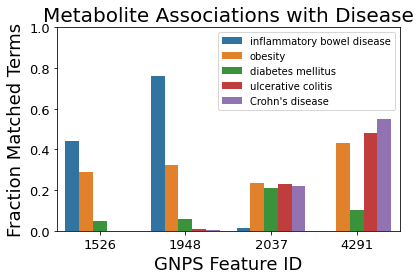

In [189]:
# filter to make DOID figure 
disease_terms = ['inflammatory bowel disease', 'obesity', 'diabetes mellitus', 
                 'ulcerative colitis', "Crohn's disease"]
disease = all_redu.loc[all_redu.Term.isin(disease_terms)]

# create figure from ReDU features 
plt.figure()
plt.ylim(0, 1)
sns.barplot(data=disease, x='FeatureID', y='Percentage', hue='Term')
plt.legend(loc='upper right')
plt.title('Metabolite Associations with Disease', fontsize=20)
ax = plt.gca()
ax.set_ylabel("Fraction Matched Terms", fontsize=18)
ax.set_xlabel("GNPS Feature ID", fontsize=18)
ax.set_xticklabels(['1526', '1948', '2037', '4291'])
ax.tick_params(labelsize=13)
plt.tight_layout()
plt.savefig('redu_fig.pdf')

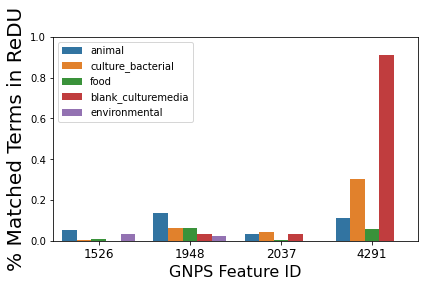

In [16]:
# filter to make sample type figure 
sample_terms = ['animal', 'culture_bacterial', 'food', 'blank_culturemedia', 'environmental']
samples = all_redu.loc[all_redu.Term.isin(sample_terms)]

# create figure from ReDU features 
plt.figure()
plt.ylim(0, 1)
sns.barplot(data=samples, x='FeatureID', y='Percentage', hue='Term')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel("% Matched Terms in ReDU", fontsize=20)
ax.set_xlabel("GNPS Feature ID", fontsize=16)
ax.set_xticklabels(['1526', '1948', '2037', '4291'], fontsize=12)
plt.tight_layout()

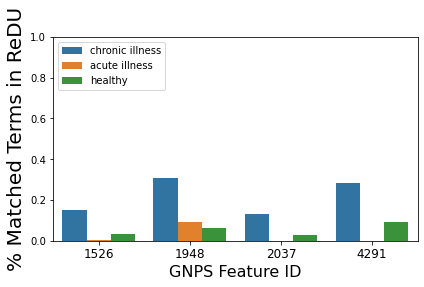

In [26]:
health_terms = ['chronic illness', 'acute illness', 'healthy']
health = all_redu.loc[all_redu.Term.isin(health_terms)]

# create figure from ReDU features 
plt.figure()
plt.ylim(0, 1)
sns.barplot(data=health, x='FeatureID', y='Percentage', hue='Term')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel("% Matched Terms in ReDU", fontsize=20)
ax.set_xlabel("GNPS Feature ID", fontsize=16)
ax.set_xticklabels(['1526', '1948', '2037', '4291'], fontsize=12)
plt.tight_layout()

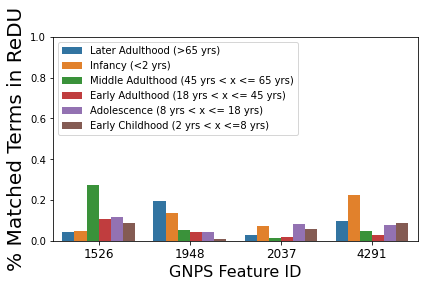

In [30]:
all_redu.loc[all_redu['Attribute'] == 'LifeStage']['Term'].unique()
life_stages = ['Infancy (<2 yrs)', 'Early Childhood (2 yrs < x <=8 yrs)',
               'Adolescence (8 yrs < x <= 18 yrs)', 'Early Adulthood (18 yrs < x <= 45 yrs)', 
               'Middle Adulthood (45 yrs < x <= 65 yrs)', 'Later Adulthood (>65 yrs)']
life = all_redu.loc[all_redu.Term.isin(life_stages)]

# create figure from ReDU features 
plt.figure()
plt.ylim(0, 1)
sns.barplot(data=life, x='FeatureID', y='Percentage', hue='Term')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel("% Matched Terms in ReDU", fontsize=20)
ax.set_xlabel("GNPS Feature ID", fontsize=16)
ax.set_xticklabels(['1526', '1948', '2037', '4291'], fontsize=12)
plt.tight_layout()